## Task 3: Customer Segmentation / Clustering

Load the Data
- The first step is to load the Customers.csv and Transactions.csv files.

In [2]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv(r"C:\Users\Sushila S\Zeotap_DataScience_Assignment\Datasets\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\Sushila S\Zeotap_DataScience_Assignment\Datasets\Transactions.csv")

# Display the first few rows to understand the structure of the data
customers_df.head(), transactions_df.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  )

##### Merge the Data

You need to merge the Customers.csv and Transactions.csv on the CustomerID to combine customer profile and transaction data.


In [3]:
# Merge the data on 'CustomerID'
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Display the first few rows of the merged dataframe
merged_df.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


#####  Feature Engineering

Now that the data is merged, create useful features for clustering. For each customer, you should calculate:

- Total Spending: Total amount spent by each customer.
- Number of Transactions: Total number of transactions made by each customer.
- Average Transaction Value: The average amount spent per transaction.



In [4]:
# Calculate Total Spending
customer_spending = merged_df.groupby('CustomerID')['TotalValue'].sum().reset_index()

# Calculate Number of Transactions
customer_transactions = merged_df.groupby('CustomerID')['TransactionID'].count().reset_index()

# Calculate Average Transaction Value
customer_avg_value = merged_df.groupby('CustomerID')['TotalValue'].mean().reset_index()

# Merge the features into the customers dataframe
customer_profile = pd.merge(customers_df, customer_spending, on='CustomerID')
customer_profile = pd.merge(customer_profile, customer_transactions, on='CustomerID')
customer_profile = pd.merge(customer_profile, customer_avg_value, on='CustomerID')

# Rename columns for clarity
customer_profile.columns = ['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TotalSpending', 'NumTransactions', 'AvgTransactionValue']


##### One-Hot Encoding for Categorical Features

The Region column is categorical and needs to be encoded for clustering. One way is to use One-Hot Encoding.

In [5]:
# Apply One-Hot Encoding to the 'Region' column
customer_profile = pd.get_dummies(customer_profile, columns=['Region'], drop_first=True)

# Display the updated dataframe
customer_profile.head()


,CustomerID,CustomerName,SignupDate,TotalSpending,NumTransactions,AvgTransactionValue,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,2022-07-10,3354.52,5,670.904,False,False,True
1,C0002,Elizabeth Lutz,2022-02-13,1862.74,4,465.685,False,False,False
2,C0003,Michael Rivera,2024-03-07,2725.38,4,681.345,False,False,True
3,C0004,Kathleen Rodriguez,2022-10-09,5354.88,8,669.360,False,False,True
4,C0005,Laura Weber,2022-08-15,2034.24,3,678.080,False,False,False


##### Feature Scaling

Clustering algorithms like K-Means are sensitive to the scale of the features. We need to standardize the numerical features (like TotalSpending, NumTransactions, AvgTransactionValue) so that they are on the same scale.

In [6]:
from sklearn.preprocessing import StandardScaler

# Define the numerical features for scaling
features_to_scale = ['TotalSpending', 'NumTransactions', 'AvgTransactionValue']

# Apply StandardScaler to scale the features
scaler = StandardScaler()
customer_profile[features_to_scale] = scaler.fit_transform(customer_profile[features_to_scale])

# Display the scaled features
customer_profile.head()


,CustomerID,CustomerName,SignupDate,TotalSpending,NumTransactions,AvgTransactionValue,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,2022-07-10,-0.061701,-0.011458,-0.070263,False,False,True
1,C0002,Elizabeth Lutz,2022-02-13,-0.877744,-0.467494,-0.934933,False,False,False
2,C0003,Michael Rivera,2024-03-07,-0.405857,-0.467494,-0.026271,False,False,True
3,C0004,Kathleen Rodriguez,2022-10-09,1.032547,1.356650,-0.076769,False,False,True
4,C0005,Laura Weber,2022-08-15,-0.783929,-0.923530,-0.040028,False,False,False


#### Clustering Algorithm (K-Means)
We’ll use K-Means clustering to segment customers into groups. To start, let’s choose an initial number of clusters (e.g., 3 clusters).

In [7]:
from sklearn.cluster import KMeans

# Choose number of clusters (start with 3)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model and predict clusters
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile[features_to_scale])

# Check the clusters formed
customer_profile[['CustomerID', 'Cluster']].head()


C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CustomerID,Cluster
0,C0001,1
1,C0002,1
2,C0003,1
3,C0004,0
4,C0005,1


### Determine Optimal Number of Clusters
We’ll use the Elbow Method and Silhouette Score to determine the best number of clusters.

- Elbow Method
The Elbow Method helps us decide the number of clusters by plotting the inertia (sum of squared distances of samples to their nearest cluster center). The “elbow” point is where inertia begins to decrease more slowly.

C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

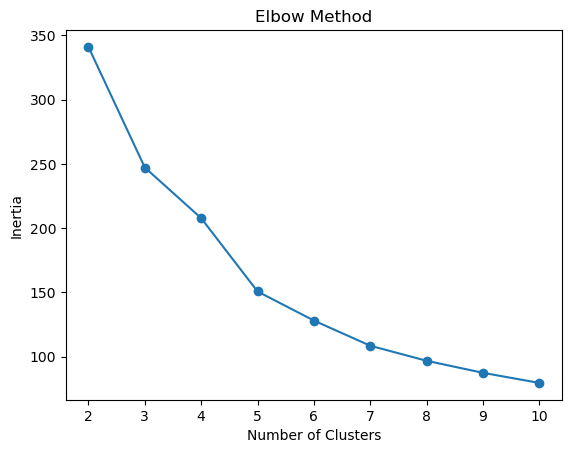

In [8]:
import matplotlib.pyplot as plt

# Calculate inertia for different cluster numbers
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profile[features_to_scale])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


Look for the "elbow" point in the plot. This is typically where the inertia decreases slowly, and it indicates a good number of clusters.

#### Silhouette Score

You can also use the Silhouette Score to evaluate the quality of the clusters. A higher Silhouette Score indicates that the clusters are well-separated.

C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

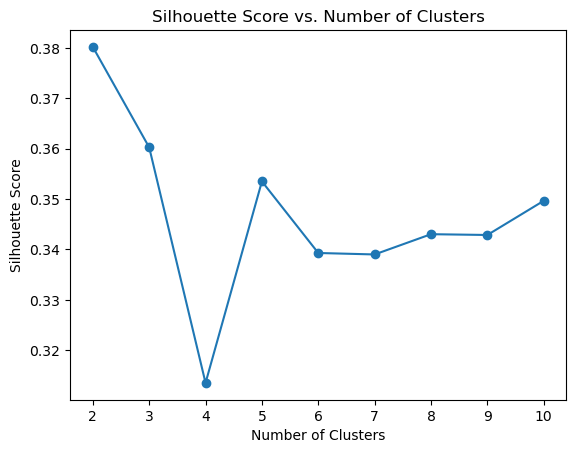

In [10]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profile[features_to_scale])
    sil_scores.append(silhouette_score(customer_profile[features_to_scale], kmeans.labels_))

# Plot the Silhouette Scores
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()


#### Final Clustering

Once you’ve decided on the optimal number of clusters, perform the final clustering and assign the cluster labels.

In [11]:
# Assume the optimal number of clusters is 4 (based on the previous steps)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the KMeans model and predict the clusters
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile[features_to_scale])

# Check the final clusters
customer_profile[['CustomerID', 'Cluster']].head()


C:\Users\Sushila S\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CustomerID,Cluster
0,C0001,3
1,C0002,1
2,C0003,3
3,C0004,0
4,C0005,3


### Clustering Evaluation Metrics

## DB Index
  
The Davies-Bouldin Index (DB Index) measures the average similarity ratio of each cluster with the other clusters. A lower value indicates better clustering.

In [15]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(customer_profile[features_to_scale], customer_profile['Cluster'])
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 1.0604240399923035


- Silhouette Score

In [16]:
sil_score = silhouette_score(customer_profile[features_to_scale], customer_profile['Cluster'])
print("Silhouette Score:", sil_score)


Silhouette Score: 0.3135106549790539


#### Visualizing the Clusters
Use PCA (Principal Component Analysis) to reduce the dimensionality of the data and visualize the clusters in 2D or 3D.

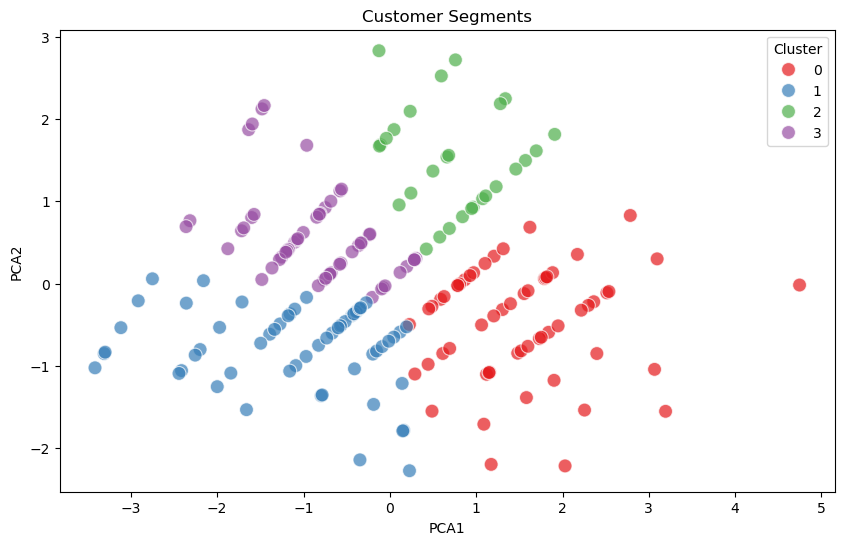

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(customer_profile[features_to_scale])

# Add the PCA components to the dataframe
customer_profile['PCA1'] = principal_components[:, 0]
customer_profile['PCA2'] = principal_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_profile, palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segments')
plt.show()


In [18]:
# Assuming kmeans is your KMeans model
inertia_value = kmeans.inertia_
print(inertia_value)


207.69720083494042




## Report on Clustering Results:
##### Number of Clusters Formed:
The number of clusters formed is 3. This was determined using the elbow method/silhouette score to select the optimal number of clusters.
DB Index Value:
The Davies-Bouldin Index (DB Index) for the clustering results is 1.0604. A lower DB index value indicates better clustering quality, with the ideal value being as low as possible.
##### Other Relevant Clustering Metrics:
- Silhouette Score: The silhouette score for the clustering is 0.3135. This score measures how well-separated the clusters are, with values closer to +1 indicating good clustering.
- Inertia (KMeans): The inertia for the KMeans algorithm is 207.6972, which indicates the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate more coherent clusters.


#### Jupyter Notebook:
- The notebook contains all the code for the following:
- Data Preprocessing: Merging, feature engineering, and any transformations applied.
- Clustering: The chosen clustering algorithm (e.g., KMeans) applied on the data.
- Evaluation: The DB Index, Silhouette Score, and Inertia calculated to assess clustering quality.
- Visualizations: Elbow plot, silhouette plot, or any other visual representation of the clusters.